In [ ]:
import os
import numpy as np
import pickle
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import flax.linen as nn
from flax.training import train_state
import optax
from tensorflow_datasets import load as tfds_load
from tqdm import tqdm
from matplotlib import pyplot as plt
from jax.experimental import pallas as pl
import jax.lax as lax

In [ ]:
# 1) Remove any mismatched installs
!pip uninstall -y jax jaxlib libtpu libtpu-nightly || true

# 2) Install JAX w/ TPU support from Google's wheel index (this pulls libtpu)
!pip install -U "jax[tpu]" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html


Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html
  Using cached jax-0.8.0-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.8.0-cp312-cp312-manylinux_2_27_x86_64.whl.metadata (1.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.4/156.4 MB 4.5 MB/s eta 0:00:00
Using cached jaxlib-0.8.0-cp312-cp312-manylinux_2_27_x86_64.whl (79.7 MB)
Using cached jax-0.8.0-py3-none-any.whl (2.9 MB)


In [ ]:
!pip install tensorflow

In [ ]:
import jax, jaxlib
print("backend:", jax.default_backend(), "devices:", jax.devices())


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


backend: tpu devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]


In [ ]:
# Config model
T = 300  # Max diffusion step
max_seq_length = 5
vocab_size = 27  # ' ': 0, 'a':1, ..., 'z':26
hidden_dim = 256

batch_size = 32
rng = random.PRNGKey(0)

In [ ]:
# Download dataset
import tensorflow_datasets as tfds

def preprocess(sample):
    image = sample['image']
    label = sample['label']
    # Convert to float32 and normalize to [0, 1]
    image = jnp.array(image, dtype=jnp.float32) / 255.0
    # Add channel dimension
    image = jnp.expand_dims(image, axis=-1)
    return image, label

# Load MNIST dataset
ds = tfds.load('mnist', split='train', as_supervised=False, shuffle_files=True)
ds = ds.shuffle(1024).batch(batch_size).prefetch(1)

# Convert to numpy iterator
def create_data_iterator(dataset):
    for batch in dataset:
        images = jnp.array(batch['image'], dtype=jnp.float32) / 255.0
        images = jnp.transpose(images, (0, 3, 1, 2))  # NHWC to NCHW
        labels = jnp.array(batch['label'])
        yield images, labels

train_data_loader = ds

In [ ]:

# Utilities
n2t_mapping = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
    10: "ten",
}

string_to_token = lambda x: [ord(i) - 96 for i in x]  # ' ': 0, 'a':1, ..., 'z':26
# token_to_string = lambda x: [chr(i + 96) for i in x] # We do not need it here


def convert_text_label(number_labels):
    text_labels = jnp.zeros((len(number_labels), max_seq_length, vocab_size))
    labels_list = []
    for bidx, nlb in enumerate(number_labels):
        label_one_hot = jnp.zeros((max_seq_length, vocab_size))
        tokens = string_to_token(n2t_mapping[int(nlb)])
        for tidx, token in enumerate(tokens):
            label_one_hot = label_one_hot.at[tidx, token].set(1.0)
        labels_list.append(label_one_hot)
    return jnp.stack(labels_list)


def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

## Pallas

In [ ]:
from jax.experimental import pallas as pl
import jax
import jax.numpy as jnp

class PallasDense(nn.Module):
    features: int
    use_bias: bool = True

    @nn.compact
    def __call__(self, x):
        n, cin = x.shape
        cout = self.features
        w = self.param("kernel", nn.initializers.lecun_normal(), (cin, cout))
        b = self.param("bias", nn.initializers.zeros, (cout,)) if self.use_bias else jnp.zeros((cout,), x.dtype)

        def kernel(x_ref, w_ref, b_ref, y_ref):
            i = pl.program_id(0)  # batch
            j = pl.program_id(1)  # out feature
            acc = jnp.array(0, dtype=x_ref.dtype)
            for k in range(cin):
                acc = acc + x_ref[i, k] * w_ref[k, j]
            acc = acc + b_ref[j] if b_ref is not None else acc
            # write a 1-element slice, not a scalar
            y_ref[i, pl.dslice(j, 1)] = jnp.asarray([acc], dtype=y_ref.dtype)

        bias_arr = b if self.use_bias else jnp.zeros((cout,), x.dtype)
        y = pl.pallas_call(
            kernel,
            out_shape=jax.ShapeDtypeStruct((n, cout), x.dtype),
            grid=(n, cout),
        )(x, w, bias_arr)
        return y


In [ ]:
from flax import linen as nn
from jax.experimental import pallas as pl
import jax
import jax.numpy as jnp

class PallasConv2D(nn.Module):
    features: int                 # Cout
    kernel_size: tuple            # (KH, KW)
    strides: tuple = (1, 1)
    padding: str = "SAME"
    use_bias: bool = True
    w_tile: int = 8               # Mosaic requires W tile % 8 == 0
    c_tile: int = 128             # Mosaic requires C tile % 128 == 0

    @nn.compact
    def __call__(self, x):
        n, h, w, cin = x.shape
        kh, kw = self.kernel_size
        cout = self.features
        sh, sw = self.strides
        WT, CT = self.w_tile, self.c_tile

        # Fallback if channel count isn't multiple of CT
        if cout % CT != 0:
            return nn.Conv(cout, self.kernel_size, self.strides, self.padding,
                           use_bias=self.use_bias)(x)

        wgt = self.param("kernel", nn.initializers.lecun_normal(),
                         (kh, kw, cin, cout))
        bias = (self.param("bias", nn.initializers.zeros, (cout,))
                if self.use_bias else None)

        # Output spatial + padding
        if self.padding == "SAME":
            oh = (h + sh - 1) // sh
            ow = (w + sw - 1) // sw
            pad_h = max((oh - 1) * sh + kh - h, 0)
            pad_w = max((ow - 1) * sw + kw - w, 0)
            pt, plf = pad_h // 2, pad_w // 2
            x_pad = jnp.pad(x, ((0,0),(pt,pad_h-pt),(plf,pad_w-plf),(0,0)))
        elif self.padding == "VALID":
            oh = (h - kh) // sh + 1
            ow = (w - kw) // sw + 1
            x_pad = x
        else:
            raise ValueError("padding must be 'SAME' or 'VALID'")

        ow_blocks = (ow + WT - 1) // WT         # ceil_div(ow, 8)
        oc_blocks = cout // CT

        # Kernel computes a (1, 1, WT, CT) tile placed statically by BlockSpec
        def kernel(x_ref, w_ref, y_ref):
            bi = pl.program_id(0)      # batch
            oy = pl.program_id(1)      # out y
            oxb = pl.program_id(2)     # out-x block (size WT=8)
            ob  = pl.program_id(3)     # out channel block (size CT=128)

            CT = 128
            WT = 8
            oc0 = ob * CT
            iy_base = oy * sh

            # compute each of the 8 lanes separately to avoid scatter_add
            for lw in range(WT):                           # WT = 8
                ox_global = oxb * WT + lw                  # traced ints ok
                def lane_body(_):
                    vec = jnp.zeros((CT,), dtype=y_ref.dtype)   # CT = 128
                    iy0 = oy * sh
                    ix0 = ox_global * sw
                    for ry in range(kh):
                        iy = iy0 + ry
                        for rx in range(kw):
                            ix = ix0 + rx
                            for ic in range(cin):
                                xval = x_ref[bi, iy, ix, ic]                          # scalar
                                wvec = w_ref[ry, rx, ic, pl.dslice(ob * CT, CT)]      # (128,)
                                vec = vec + xval * wvec
                    return vec

                # If ox_global is outside [0, ow), skip computing & store zeros.
                vec = lax.cond(ox_global < ow, lane_body,
                              lambda _: jnp.zeros((CT,), dtype=y_ref.dtype),
                              operand=None)

                # tile-local store (no dynamic store)
                y_ref[0, 0, lw, :] = vec

        out_specs = pl.BlockSpec(
            (1, 1, WT, CT),
            lambda bi, oy, oxb, ob: (bi, oy, oxb * WT, ob * CT),
        )

        y = pl.pallas_call(
            kernel,
            out_shape=jax.ShapeDtypeStruct((n, oh, ow, cout), x.dtype),
            grid=(n, oh, ow_blocks, oc_blocks),
            out_specs=out_specs,       # static tile placement (…, WT, CT)
        )(x_pad, wgt)

        if self.use_bias:
            y = y + bias[None, None, None, :]
        return y


In [ ]:
class PallasConvTranspose2D(nn.Module):
    features: int
    kernel_size: tuple
    strides: tuple = (2, 2)
    padding: str = "SAME"
    use_bias: bool = True

    @nn.compact
    def __call__(self, x):
        n, h, w, cin = x.shape
        kh, kw = self.kernel_size
        cout = self.features
        sh, sw = self.strides

        # HWOC (kh,kw, Cout, Cin) for transposed conv scatter
        wgt = self.param("kernel", nn.initializers.lecun_normal(), (kh, kw, cout, cin))
        bias = self.param("bias", nn.initializers.zeros, (cout,)) if self.use_bias else jnp.zeros((cout,), x.dtype)

        if self.padding == "SAME":
            oh, ow = h * sh, w * sw
            pt = plf = 0
        elif self.padding == "VALID":
            oh, ow = (h - 1) * sh + kh, (w - 1) * sw + kw
            pt = plf = 0
        else:
            raise ValueError("padding must be 'SAME' or 'VALID'")

        def kernel(x_ref, w_ref, y_ref):
            bi = pl.program_id(0)
            iy = pl.program_id(1)
            ix = pl.program_id(2)
            ic = pl.program_id(3)

            val = x_ref[bi, iy, ix, ic]
            oy0 = iy * sh - pt
            ox0 = ix * sw - plf

            for ry in range(kh):
                oy = oy0 + ry
                if (oy < 0) or (oy >= oh):
                    continue
                for rx in range(kw):
                    ox = ox0 + rx
                    if (ox < 0) or (ox >= ow):
                        continue
                    for oc in range(cout):
                        contrib = val * w_ref[ry, rx, oc, ic]
                        # atomic add into 1-length slice
                        pl.atomic_add(
                            y_ref,
                            (bi, oy, ox, pl.dslice(oc, 1)),             # dynamic 1-length slice
                            jnp.asarray([contrib], dtype=y_ref.dtype),  # keep 1-D payload
                        )

        y = pl.pallas_call(
            kernel,
            out_shape=jax.ShapeDtypeStruct((n, oh, ow, cout), x.dtype),
            grid=(n, h, w, cin),
        )(x, wgt)
        if self.use_bias:
            y = y + bias
        return y


In [ ]:
class ResidualConvBlock(nn.Module):
    in_channels: int
    out_channels: int
    is_res: bool = False
    training: bool = True

    @nn.compact
    def __call__(self, x, training=None):
        if training is None:
            training = self.training

        x1 = PallasConv2D(self.out_channels, kernel_size=(3, 3),
                          strides=(1, 1), padding="SAME")(x)
        x1 = nn.BatchNorm(use_running_average=not training)(x1)
        x1 = nn.gelu(x1)

        x2 = PallasConv2D(self.out_channels, kernel_size=(3, 3),
                          strides=(1, 1), padding="SAME")(x1)
        x2 = nn.BatchNorm(use_running_average=not training)(x2)
        x2 = nn.gelu(x2)

        if self.is_res:
            same_channels = self.in_channels == self.out_channels
            out = (x if same_channels else x1) + x2
            return out / 1.414
        else:
            return x2


class UnetDown(nn.Module):
    in_channels: int
    out_channels: int

    @nn.compact
    def __call__(self, x, training=True):
        x = ResidualConvBlock(self.in_channels, self.out_channels)(x, training=training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        return x


class UnetUp(nn.Module):
    in_channels: int
    out_channels: int

    @nn.compact
    def __call__(self, x, skip, training=True):
        x = jnp.concatenate([x, skip], axis=-1)  # NHWC
        x = PallasConvTranspose2D(self.out_channels, kernel_size=(2, 2),
                                  strides=(2, 2), padding="SAME")(x)
        x = ResidualConvBlock(self.out_channels, self.out_channels)(x, training=training)
        x = ResidualConvBlock(self.out_channels, self.out_channels)(x, training=training)
        return x

class EmbedFC(nn.Module):
    input_dim: int
    emb_dim: int

    @nn.compact
    def __call__(self, x):
        x = x.reshape(-1, self.input_dim)
        x = PallasDense(self.emb_dim)(x)
        x = nn.gelu(x)
        x = PallasDense(self.emb_dim)(x)
        return x


class ContextUnet(nn.Module):
    in_channels: int
    n_feat: int = 256
    n_classes: int = 10

    @nn.compact
    def __call__(self, x, c, t, context_mask, training=True):
        # NCHW -> NHWC
        x_orig = jnp.transpose(x, (0, 2, 3, 1))

        x = ResidualConvBlock(self.in_channels, self.n_feat, is_res=True)(x_orig, training=training)
        down1 = UnetDown(self.n_feat, self.n_feat)(x, training=training)
        down2 = UnetDown(self.n_feat, 2 * self.n_feat)(down1, training=training)

        hiddenvec = jnp.mean(down2, axis=(1, 2), keepdims=True)
        hiddenvec = nn.gelu(hiddenvec)

        context_mask = -1 * (1 - context_mask)
        c = c * context_mask

        cemb1 = PallasDense(2 * self.n_feat)(c.reshape(c.shape[0], -1))
        cemb1 = cemb1.reshape(-1, 1, 1, 2 * self.n_feat)

        cemb2 = PallasDense(1 * self.n_feat)(c.reshape(c.shape[0], -1))
        cemb2 = cemb2.reshape(-1, 1, 1, 1 * self.n_feat)

        temb1 = EmbedFC(1, 2 * self.n_feat)(t)
        temb1 = temb1.reshape(-1, 1, 1, 2 * self.n_feat)

        temb2 = EmbedFC(1, 1 * self.n_feat)(t)
        temb2 = temb2.reshape(-1, 1, 1, 1 * self.n_feat)

        # upsample from 1x1 to 7x7 with stride 7
        up1 = PallasConvTranspose2D(2 * self.n_feat, kernel_size=(7, 7),
                                    strides=(7, 7), padding="VALID")(hiddenvec)
        up1 = nn.GroupNorm(8)(up1)
        up1 = nn.relu(up1)

        up2_input = cemb1 * up1 + temb1
        up2 = UnetUp(4 * self.n_feat, self.n_feat)(up2_input, down2, training=training)

        esp_theta_w_context_input = cemb2 * up2 + temb2
        esp_theta_w_context = UnetUp(2 * self.n_feat, self.n_feat)(
            esp_theta_w_context_input, down1, training=training
        )

        # Without-context path (x already NHWC of width n_feat)
        t_broadcast = t[:, None, None, :]
        esp_theta_wo_context = x + t_broadcast

        out = jnp.concatenate([esp_theta_w_context, esp_theta_wo_context], axis=-1)
        out = PallasConv2D(self.n_feat, kernel_size=(3, 3), strides=(1, 1), padding="SAME")(out)
        out = nn.GroupNorm(8)(out)
        out = nn.relu(out)
        out = PallasConv2D(self.in_channels, kernel_size=(3, 3), strides=(1, 1), padding="SAME")(out)

        # NHWC -> NCHW
        out = jnp.transpose(out, (0, 3, 1, 2))
        return out


In [ ]:
# Initialize model
model = ContextUnet(in_channels=1, n_feat=hidden_dim, n_classes=vocab_size)

# Create a sample input for initialization
rng, init_rng = random.split(rng)
sample_x = jnp.ones((1, 1, 28, 28))
sample_c = jnp.ones((1, max_seq_length, vocab_size))
sample_t = jnp.ones((1, 1))
sample_mask = jnp.zeros((1, max_seq_length, vocab_size))

variables = model.init(init_rng, sample_x, sample_c, sample_t, sample_mask, training=True)

# Create optimizer
learning_rate = 1e-4
tx = optax.adam(learning_rate)

# Create training state - include batch_stats
class TrainState(train_state.TrainState):
    batch_stats: dict

state = TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=tx,
    batch_stats=variables['batch_stats'],
)

MosaicError: INTERNAL: Mosaic failed to compile TPU kernel: Not implemented: dynamic load with unaligned indices

The MLIR operation involved:
  %157609 = "vector.load"(%269, %145571, %145572, %157608, %264) {in_layout = [#tpu.vpad<"none">, #tpu.vpad<"none">, #tpu.vpad<"none">, #tpu.vpad<"none">, #tpu.vpad<"none">], out_layout = [#tpu.vpad<"32,{*,0},(8,128)">]} : (memref<1x30x32x256xf32, #tpu.memory_space<vmem>>, index, index, index, index) -> vector<1x1x1x1xf32>

Please report a bug at: https://github.com/google/jax/issues/new?assignees=apaszke


In [ ]:
# Load saved models
# import pickle
# with open('contextual_model_params.pkl', 'rb') as f:
#     loaded_params = pickle.load(f)
# state = state.replace(params=loaded_params)
#
# with open('beta_t.pkl', 'rb') as f:
#     beta_t = pickle.load(f)

In [ ]:
# Setting hyperparameters for diffusion process
beta_1 = 1e-4
beta_2 = 2e-2
beta_t = (beta_2 - beta_1) * jnp.arange(0, T + 1, dtype=jnp.float32) / T + beta_1

alpha_t = 1 - beta_t
alphabar_t = jnp.exp(jnp.cumsum(jnp.log(alpha_t), axis=0))

sqrtab = jnp.sqrt(alphabar_t)
sqrtmab = jnp.sqrt(1 - alphabar_t)

sqrt_beta_t = jnp.sqrt(beta_t)
oneover_sqrta = 1 / jnp.sqrt(alpha_t)
mab_over_sqrtmab = (1 - alpha_t) / sqrtmab

In [ ]:
# TRAINING
@jit
def train_step(state, x_in, context, t, esp, context_mask, t_norm):
    def loss_fn(params):
        # Forward pass with batch_stats
        x_t = sqrtab[t, None, None, None] * x_in + sqrtmab[t, None, None, None] * esp
        variables = {'params': params, 'batch_stats': state.batch_stats}
        esp_theta, new_model_state = state.apply_fn(
            variables, x_t, context, t_norm, context_mask,
            training=True,
            mutable=['batch_stats']
        )

        # MSE loss
        loss = jnp.mean((esp - esp_theta) ** 2)
        return loss, new_model_state

    (loss, new_model_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=new_model_state['batch_stats'])
    return state, loss

EPOCHS = 1

for e in range(EPOCHS):
    print(f"========== EPOCH {e} ==========")
    total_loss = 0
    batch_idx = 0

    for batch in tqdm(train_data_loader, desc=f"Epoch {e + 1}"):
        # Input preparation
        images = jnp.array(batch['image'], dtype=jnp.float32) / 255.0
        x_in = jnp.transpose(images, (0, 3, 1, 2))  # NHWC to NCHW
        labels = jnp.array(batch['label'])

        context = convert_text_label(labels)

        # Forward diffusion
        rng, t_rng, esp_rng, mask_rng = random.split(rng, 4)

        # Sample random timesteps
        t = random.randint(t_rng, (x_in.shape[0],), 1, T)

        # Sample noise
        esp = random.normal(esp_rng, x_in.shape)

        # Sample context mask
        context_mask = random.bernoulli(mask_rng, 0.1, context.shape)

        # Normalize timesteps
        t_norm = (t / T).astype(jnp.float32)
        t_norm = t_norm[:, None]  # Add dimension for embedding

        # Training step
        state, loss = train_step(state, x_in, context, t, esp, context_mask, t_norm)

        total_loss += float(loss)
        if batch_idx % 100 == 0:
            print(f"\tLoss: {loss:.4f}")

        batch_idx += 1

    print(f"Average Loss: {total_loss / batch_idx:.4f}")

========== EPOCH 0 ==========


Epoch 1:   0%|          | 2/1875 [01:17<16:34:00, 31.84s/it]

	Loss: 1.2359


Epoch 1:   5%|▌         | 101/1875 [01:36<06:31,  4.53it/s]

	Loss: 0.1133


Epoch 1:  11%|█         | 202/1875 [01:56<05:06,  5.45it/s]

	Loss: 0.0692


Epoch 1:  16%|█▌        | 302/1875 [02:15<05:02,  5.20it/s]

	Loss: 0.0495


Epoch 1:  21%|██▏       | 401/1875 [02:36<05:07,  4.79it/s]

	Loss: 0.0498


Epoch 1:  27%|██▋       | 502/1875 [02:55<04:18,  5.31it/s]

	Loss: 0.0790


Epoch 1:  32%|███▏      | 602/1875 [03:15<04:01,  5.28it/s]

	Loss: 0.0740


Epoch 1:  37%|███▋      | 702/1875 [03:34<03:22,  5.79it/s]

	Loss: 0.0446


Epoch 1:  43%|████▎     | 802/1875 [03:53<03:22,  5.30it/s]

	Loss: 0.0494


Epoch 1:  48%|████▊     | 902/1875 [04:13<02:53,  5.62it/s]

	Loss: 0.0391


Epoch 1:  53%|█████▎    | 1002/1875 [04:32<02:49,  5.16it/s]

	Loss: 0.0547


Epoch 1:  59%|█████▊    | 1101/1875 [04:51<02:38,  4.88it/s]

	Loss: 0.0361


Epoch 1:  64%|██████▍   | 1202/1875 [05:11<02:08,  5.24it/s]

	Loss: 0.0340


Epoch 1:  69%|██████▉   | 1302/1875 [05:31<01:50,  5.21it/s]

	Loss: 0.0338


Epoch 1:  75%|███████▍  | 1402/1875 [05:50<01:31,  5.20it/s]

	Loss: 0.0430


Epoch 1:  80%|████████  | 1501/1875 [06:08<01:14,  5.00it/s]

	Loss: 0.0596


Epoch 1:  85%|████████▌ | 1602/1875 [06:28<00:53,  5.12it/s]

	Loss: 0.0432


Epoch 1:  91%|█████████ | 1702/1875 [06:48<00:32,  5.27it/s]

	Loss: 0.0346


Epoch 1:  96%|█████████▌| 1802/1875 [07:07<00:14,  5.11it/s]

	Loss: 0.0474


Epoch 1: 100%|██████████| 1875/1875 [07:21<00:00,  4.25it/s]

Average Loss: 0.0593


In [ ]:
# Save models
with open('contextual_model_params.pkl', 'wb') as f:
    pickle.dump(state.params, f)
with open('beta_t.pkl', 'wb') as f:
    pickle.dump(np.array(beta_t), f)

In [ ]:
# SAMPLING
def sampling_imgs(state, list_numbers, return_steps=[], mode="ddpm", rng_key=None):
    if rng_key is None:
        rng_key = random.PRNGKey(42)

    rng_key, noise_rng = random.split(rng_key)
    x_T = random.normal(noise_rng, (len(list_numbers), 1, 28, 28))

    context = convert_text_label(jnp.array(list_numbers))
    context_mask = jnp.zeros_like(context)

    x_t = x_T
    if len(return_steps) > 0:
        reverse_steps = []

    # Reverse diffusion
    for t in tqdm(range(T, 0, -1)):
        if t in return_steps:
            reverse_steps.append(np.array(x_t))

        norm_t = jnp.array([t / T]).repeat(len(list_numbers))
        norm_t = norm_t[:, None]

        # Use batch_stats in inference mode (training=False)
        variables = {'params': state.params, 'batch_stats': state.batch_stats}
        esp_theta = state.apply_fn(variables, x_t, context, norm_t, context_mask, training=False)

        if mode == "ddpm":  # Probabilistic
            sigma = (
                jnp.sqrt((1 - alphabar_t[t - 1]) / (1 - alphabar_t[t]))
                * sqrt_beta_t[t]
            )

            if t > 1:
                rng_key, z_rng = random.split(rng_key)
                z = random.normal(z_rng, (len(list_numbers), 1, 28, 28))
            else:
                z = 0

            x_t = (
                oneover_sqrta[t] * (x_t - esp_theta * mab_over_sqrtmab[t]) + sigma * z
            )

        elif mode == "ddim":  # Deterministic
            sigma = 1e-3

            if t > 1:
                rng_key, z_rng = random.split(rng_key)
                z = random.normal(z_rng, (len(list_numbers), 1, 28, 28))
            else:
                z = 0

            x_t = (
                oneover_sqrta[t] * (x_t - esp_theta * sqrtmab[t])
                + esp_theta * jnp.sqrt(1 - alphabar_t[t - 1] - sigma**2)
                + sigma * z
            )

    if len(return_steps) > 0:
        reverse_steps.append(np.array(x_t))
        return reverse_steps

    return np.array(x_t)

100%|██████████| 300/300 [00:55<00:00,  5.43it/s]


Number 'zero'


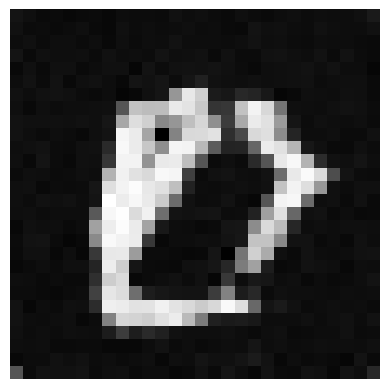

Number 'one'


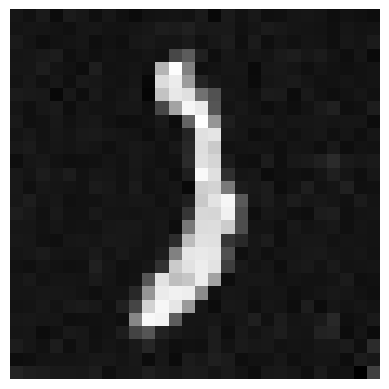

Number 'two'


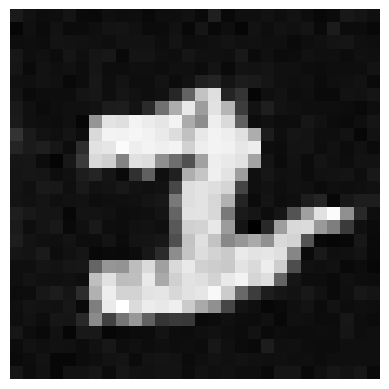

Number 'three'


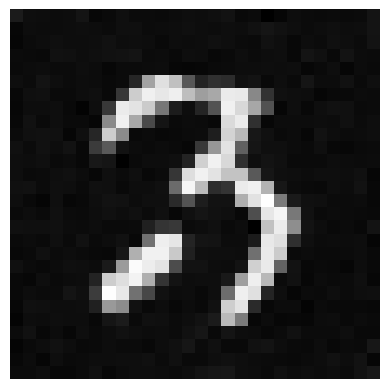

Number 'four'


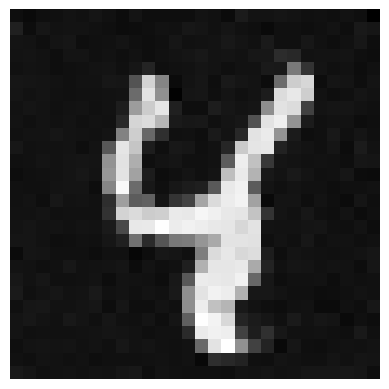

Number 'five'


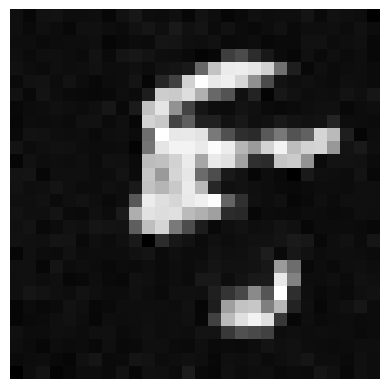

Number 'six'


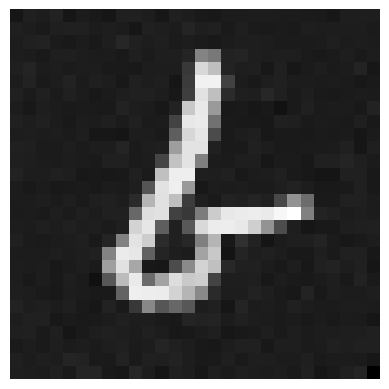

Number 'seven'


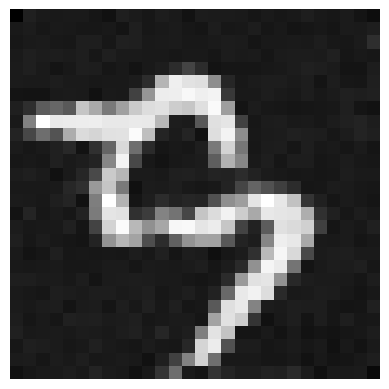

Number 'eight'


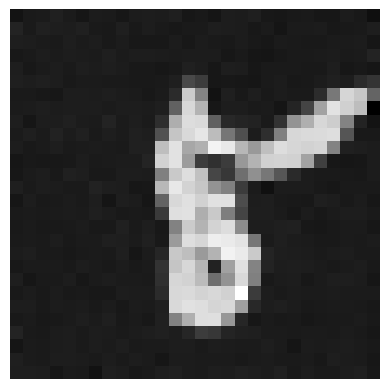

Number 'nine'


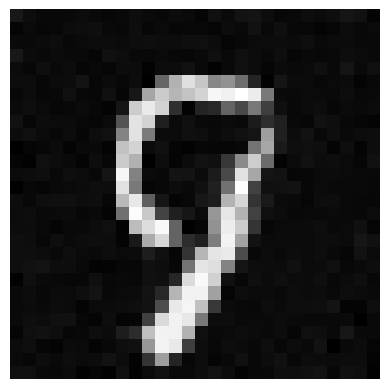

Number 'ten'


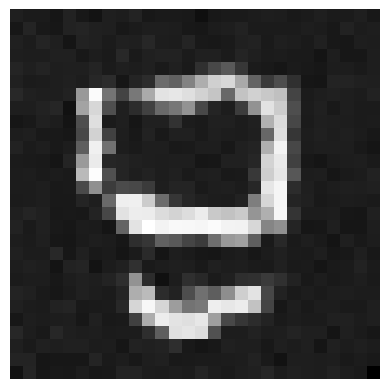

In [ ]:
# Run testing DDIM
test_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sampled_imgs = sampling_imgs(state, test_numbers, mode="ddim")

# Visualize testing results
for idx in range(len(test_numbers)):
    print(f"Number '{n2t_mapping[test_numbers[idx]]}'")

    max_v = np.max(sampled_imgs[idx][0])
    min_v = np.min(sampled_imgs[idx][0])
    img = (sampled_imgs[idx][0] - min_v) / (max_v - min_v)
    show_img(img)

100%|██████████| 300/300 [00:38<00:00,  7.70it/s]

Number 'zero'


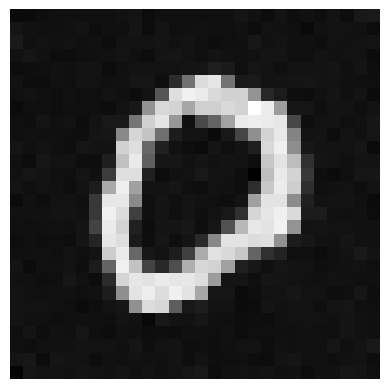

Number 'one'


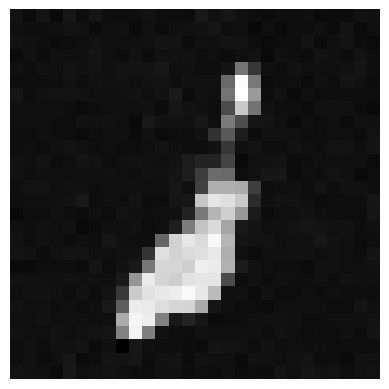

Number 'two'


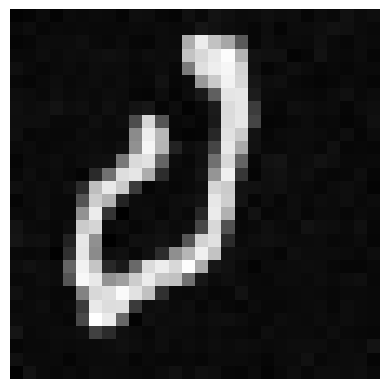

Number 'three'


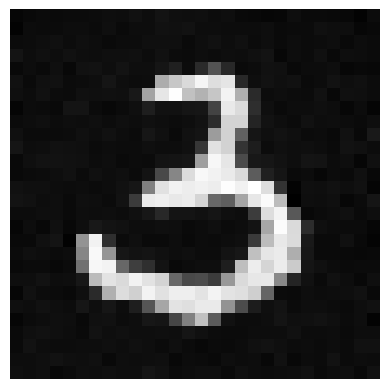

Number 'four'


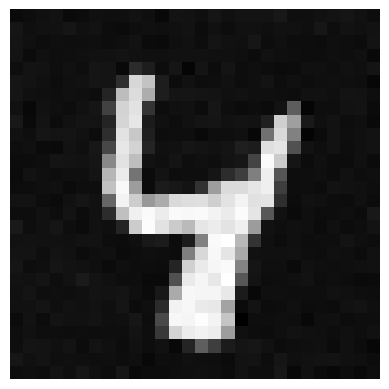

Number 'five'


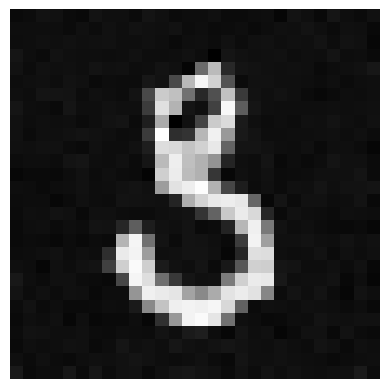

Number 'six'


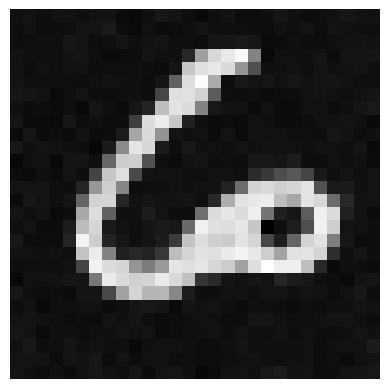

Number 'seven'


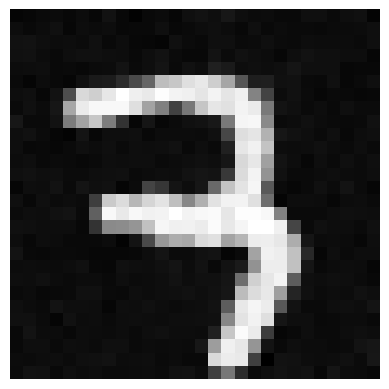

Number 'eight'


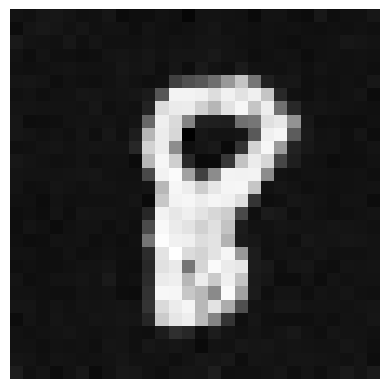

Number 'nine'


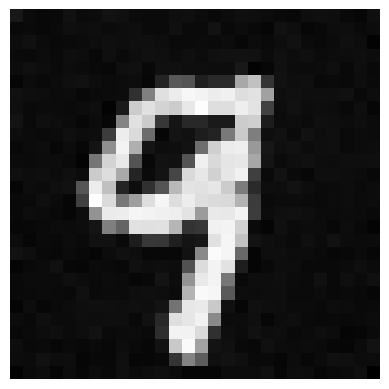

Number 'ten'


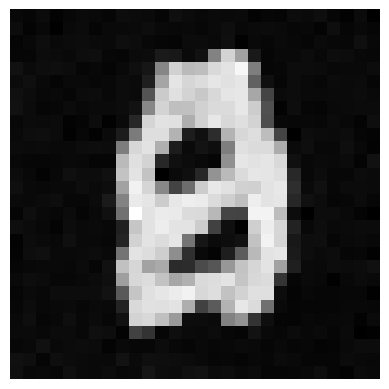

In [ ]:
# Run testing DDPM
test_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sampled_imgs = sampling_imgs(state, test_numbers, mode="ddpm")

# Visualize testing results
for idx in range(len(test_numbers)):
    print(f"Number '{n2t_mapping[test_numbers[idx]]}'")

    max_v = np.max(sampled_imgs[idx][0])
    min_v = np.min(sampled_imgs[idx][0])
    img = (sampled_imgs[idx][0] - min_v) / (max_v - min_v)
    show_img(img)

100%|██████████| 300/300 [00:39<00:00,  7.65it/s]



Number: ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
Step: 300


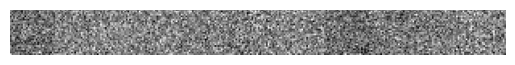

Step: 250


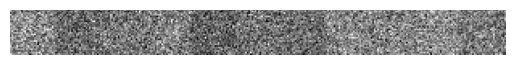

Step: 200


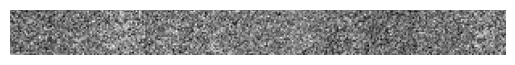

Step: 150


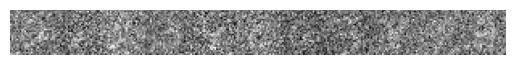

Step: 100


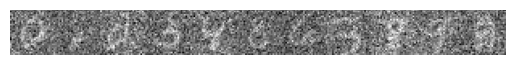

Step: 50


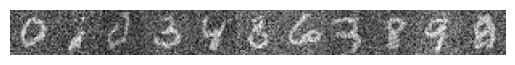

Step: 0


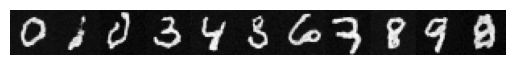

In [ ]:
test_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
steps = list(range(T, -1, -50))

reverse_steps = sampling_imgs(state, test_numbers, return_steps=steps)

print("\n=========================\n")
print("Number:", [n2t_mapping[x] for x in test_numbers])

for sidx, step in enumerate(steps):
    print("Step:", step)
    step_img = []

    for idx in range(len(test_numbers)):
        max_v = np.max(reverse_steps[sidx][idx][0])
        min_v = np.min(reverse_steps[sidx][idx][0])
        img = (reverse_steps[sidx][idx][0] - min_v) / (max_v - min_v)
        step_img.append(img)

    step_img = np.concatenate(step_img, axis=-1)
    show_img(step_img)

In [ ]:
# Save to Google Drive (optional - uncomment if using Colab)
# !cp contextual_model_params.pkl "/content/drive/MyDrive/Colab Notebooks/Diffusion/contextual_model_params.pkl"
# !cp beta_t.pkl "/content/drive/MyDrive/Colab Notebooks/Diffusion/beta_t.pkl"